In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
import pyomo as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [3]:
def plot_meritOrder(bids, results=None):
    """
    Plot the merit order of bids for each node in a separate subplot
    """
    number_of_nodes = len(bids.keys())

    fig, ax = plt.subplots(1, number_of_nodes, sharey=True)

    # split the bids into buy and sell bids for each node separately
    for i in range(number_of_nodes):
        # split the bids into buy and sell bids in lists of tuples
        supply_bids = [
            (price, quantity) for price, quantity in bids[i].values() if quantity > 0
        ]
        demand_bids = [
            (price, -quantity) for price, quantity in bids[i].values() if quantity < 0
        ]

        # sort the bids by price
        supply_bids.sort(key=lambda x: x[0])
        demand_bids.sort(key=lambda x: x[0], reverse=True)

        # find the cumulative sum of the quantity of the bids
        cum_supply_bids = 0
        # find the cumulative sum of the quantity of the bids
        cum_demand_bids = 0

        # iterate through supply bids and plot them
        for n, bid in enumerate(supply_bids):
            price, quantity = bid
            ax[i].plot(
                [cum_supply_bids, cum_supply_bids + quantity], [price, price], "b-"
            )
            cum_supply_bids += quantity
            if n < len(supply_bids) - 1:
                ax[i].plot(
                    [cum_supply_bids, cum_supply_bids],
                    [price, supply_bids[n + 1][0]],
                    "b-",
                )
        # iterate through demand bids and plot them
        for n, bid in enumerate(demand_bids):
            price, quantity = bid
            ax[i].plot(
                [cum_demand_bids, cum_demand_bids + quantity], [price, price], "r-"
            )
            cum_demand_bids += quantity
            if n < len(demand_bids) - 1:
                ax[i].plot(
                    [cum_demand_bids, cum_demand_bids],
                    [price, demand_bids[n + 1][0]],
                    "r-",
                )
        # plot the market clearing price and quantity
        price = results[i][0]
        contracted_supply = results[i][1]
        contracetd_demand = results[i][2]
        inflow = results[i][3]
        ax[i].plot([contracted_supply, contracted_supply], [0, price], "k--")
        ax[i].plot([0, contracted_supply], [price, price], "k--")
        ax[i].plot(contracted_supply, price, "ko")

        # add text under the plot to show the market clearing price and quantity
        ax[i].text(0.05, -0.3, "Results:", transform=ax[i].transAxes)
        ax[i].text(0.05, -0.375, f"Price: {price:.1f}", transform=ax[i].transAxes)
        ax[i].text(
            0.05,
            -0.45,
            f"Accepted supply: {contracted_supply:.1f}",
            transform=ax[i].transAxes,
        )
        ax[i].text(
            0.05,
            -0.525,
            f"Accepted demand: {contracetd_demand:.1f}",
            transform=ax[i].transAxes,
        )
        ax[i].text(0.05, -0.6, f"Total Export: {inflow:.1f}", transform=ax[i].transAxes)
        ax[i].set_title(f"Node {str(i)}")
        ax[i].set_xlabel("Quantity")
        ax[i].set_ylabel("Price")

        # plot legend outside the plot and only for last subplot
        if i == number_of_nodes - 1:
            ax[i].legend(
                handles=[
                    Line2D([0], [0], 1, color="b", label="Supply"),
                    Line2D([0], [0], 1, color="r", label="Demand"),
                ],
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0.0,
            )

        # set x limits to 0 and max of supply or demand
        ax[i].set_xlim(0, max(cum_supply_bids, cum_demand_bids))
        ax[i].set_ylim(bottom=0)
    plt.subplots_adjust(wspace=0.3)

    return fig, ax

In [7]:
def marketClearingLP(bids, network, nodes, plot=False, printMatrix=False):
    """
    Formulate a market clearing problem as a linear program and solve it pyomo
    inputs:
        bids: dict of dicts of tuples of (price, quantity)
    outputs:
        price: float
        quantity: float
    """
    # create an incidence matrix to store the flow over each line
    incidence_matrix = pd.DataFrame(0, index=nodes, columns=network)
    for i, (node1, node2, capacity) in network.items():
        incidence_matrix.at[node1, i] = 1
        incidence_matrix.at[node2, i] = -1

    if printMatrix:
        print(incidence_matrix)

    # Split suppy and demand bids into two lists
    demand_bids = []
    supply_bids = []
    for node in nodes:
        for bid_id, (price, quantity) in bids[node].items():
            if quantity > 0:
                supply_bids.append((node, price, quantity, bid_id))
            else:
                demand_bids.append((node, price, -quantity, bid_id))

    # Create a model
    model = ConcreteModel()

    model.dual = Suffix(direction=Suffix.IMPORT_EXPORT)

    # Create power variable for generation and consumption
    model.p_generation = Var(range(len(supply_bids)), domain=NonNegativeReals)
    model.p_consumption = Var(range(len(demand_bids)), domain=NonNegativeReals)

    # Create a set for the lines in the network
    model.lines = Set(initialize=network.keys())
    # Create a variable for the flow over each line
    model.flow = Var(model.lines, domain=Reals)

    # Create a constraint that the flow over each line must be less than or equal to the capacity of the line
    model.capacity_constraint = ConstraintList()
    for i, (node1, node2, capacity) in network.items():
        model.capacity_constraint.add(model.flow[i] <= capacity)
        model.capacity_constraint.add(model.flow[i] >= -capacity)

    # Create a constraint that the flow over each line must be less than or equal to the capacity of the line
    model.balance_constraint = ConstraintList()
    for node in nodes:
        model.balance_constraint.add(
            sum(
                model.p_generation[i]
                for i in range(len(supply_bids))
                if supply_bids[i][0] == node
            )
            - sum(incidence_matrix.at[node, i] * model.flow[i] for i in network.keys())
            - sum(
                model.p_consumption[i]
                for i in range(len(demand_bids))
                if demand_bids[i][0] == node
            )
            == 0
        )

    # Maximum power generation constraint
    model.max_generation = ConstraintList()
    for i, (node, price, quantity, bid_id) in enumerate(supply_bids):
        model.max_generation.add(model.p_generation[i] <= quantity)

    # Maximum power consumption constraint
    model.max_consumption = ConstraintList()
    for i, (node, price, quantity, bid_id) in enumerate(demand_bids):
        model.max_consumption.add(model.p_consumption[i] <= quantity)

    # Obective function
    model.obj = Objective(
        expr=sum(
            model.p_consumption[i] * demand_bids[i][1] for i in range(len(demand_bids))
        )
        - sum(
            model.p_generation[i] * supply_bids[i][1] for i in range(len(supply_bids))
        ),
        sense=maximize,
    )

    # Create a solver
    solver = SolverFactory("glpk")  # glpk

    # Solve the model
    solver.solve(model)

    # Find the dual variable for the balance constraint
    duals_dict = {str(key): -model.dual[key] for key in model.dual.keys()}

    # Find sum of generation per node
    generation = {
        node: sum(
            model.p_generation[i]()
            for i in range(len(supply_bids))
            if supply_bids[i][0] == node
        )
        for node in nodes
    }

    # Find sum of generation per node
    consumption = {
        node: sum(
            model.p_consumption[i]()
            for i in range(len(demand_bids))
            if demand_bids[i][0] == node
        )
        for node in nodes
    }

    # Find sum of power flowing into each node
    power_in = {
        node: sum(
            incidence_matrix.at[node, i] * model.flow[i]() for i in network.keys()
        )
        for node in nodes
    }

    results = {
        node: (
            duals_dict[f"balance_constraint[{node+1}]"],
            generation[node],
            consumption[node],
            power_in[node],
        )
        for node in nodes
    }
    if plot:
        fig, ax = plot_meritOrder(bids, results)
    return results

0.07908296585083008


/tmp/ipykernel_675851/2635087338.py:59: MatplotlibDeprecationWarning: Passing the linewidth parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax[i].legend(handles = [Line2D([0], [0], 1, color = 'b', label='Supply'),
/tmp/ipykernel_675851/2635087338.py:60: MatplotlibDeprecationWarning: Passing the linewidth parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Line2D([0], [0], 1, color= 'r', label='Demand')],


1.2605035305023193


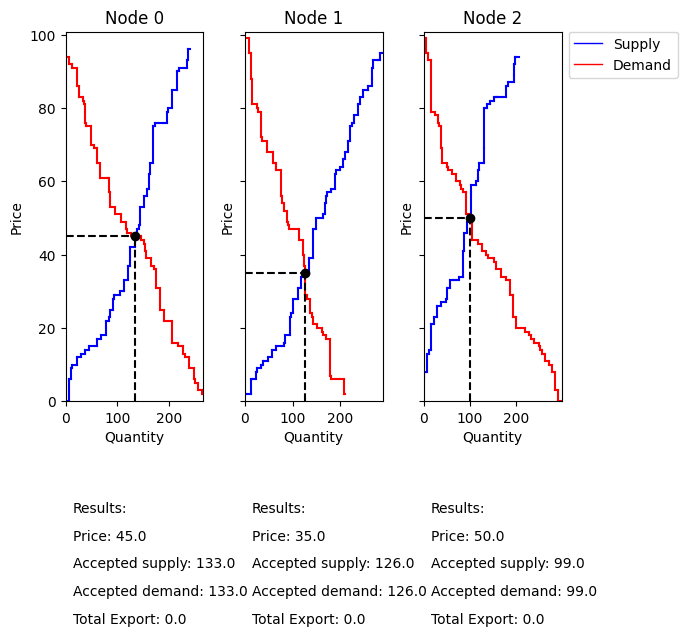

In [14]:
# define list of nodes
nodes = [0, 1, 2]

# define a dict with connections between nodes as a tupple of (node1, node2, capacity)
network = {"Line_0": (0, 1, 0), "Line_1": (1, 2, 0), "Line_2": (2, 0, 0)}


# define a dict of dicts to store bids for each node where each bid is a tuple of (price, quantity)
# negative quantity means a bid to sell and positive quantity means a bid to buy
bids = {0: {}, 1: {}, 2: {}}


np.random.seed(30)
for node, i in itertools.product(bids, range(100)):
    bids[node][i] = (np.random.randint(100), np.random.randint(-10, 10))


import time

t = time.time()
results = marketClearingLP(bids, network, nodes, plot=False)
print(time.time() - t)

t = time.time()
results = marketClearingLP(bids, network, nodes, plot=True)
print(time.time() - t)

In [11]:
bids

{0: {0: (37, -5),
  1: (45, 3),
  2: (12, -8),
  3: (53, 7),
  4: (46, -7),
  5: (41, -3),
  6: (65, 7),
  7: (45, -7),
  8: (18, 8),
  9: (76, 6),
  10: (6, 4),
  11: (45, -10),
  12: (62, 1),
  13: (15, -6),
  14: (13, 8),
  15: (33, 7),
  16: (58, 4),
  17: (57, -2),
  18: (75, 3),
  19: (44, -5),
  20: (75, -3),
  21: (9, -9),
  22: (47, -3),
  23: (36, -2),
  24: (25, 6),
  25: (69, -1),
  26: (90, 4),
  27: (91, 9),
  28: (30, 7),
  29: (93, 2),
  30: (61, -8),
  31: (79, 1),
  32: (28, 2),
  33: (51, -1),
  34: (56, 6),
  35: (39, -9),
  36: (9, 1),
  37: (92, -6),
  38: (98, 0),
  39: (79, 1),
  40: (17, -1),
  41: (45, -3),
  42: (48, 2),
  43: (80, 9),
  44: (45, 2),
  45: (23, 1),
  46: (29, 2),
  47: (29, 9),
  48: (76, 9),
  49: (85, 9),
  50: (6, -3),
  51: (98, 0),
  52: (30, 2),
  53: (83, -8),
  54: (47, 4),
  55: (13, -3),
  56: (15, 9),
  57: (22, -7),
  58: (70, -6),
  59: (76, 8),
  60: (22, -8),
  61: (91, -1),
  62: (76, -1),
  63: (51, -10),
  64: (14, 8),
  65:

   Line_0  Line_1  Line_2
0       1       0      -1
1      -1       1       0
2       0      -1       1


/tmp/ipykernel_675851/2635087338.py:59: MatplotlibDeprecationWarning: Passing the linewidth parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax[i].legend(handles = [Line2D([0], [0], 1, color = 'b', label='Supply'),
/tmp/ipykernel_675851/2635087338.py:60: MatplotlibDeprecationWarning: Passing the linewidth parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Line2D([0], [0], 1, color= 'r', label='Demand')],


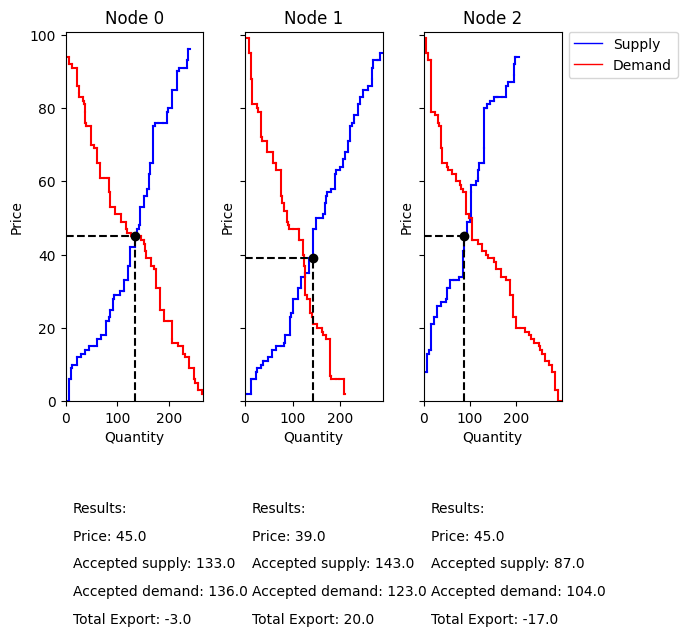

In [9]:
network = {"Line_0": (0, 1, 10), "Line_1": (1, 2, 10), "Line_2": (2, 0, 10)}

results = marketClearingLP(bids, network, nodes, plot=True, printMatrix=True)

   Line_0  Line_1  Line_2
0       1       0      -1
1      -1       1       0
2       0      -1       1


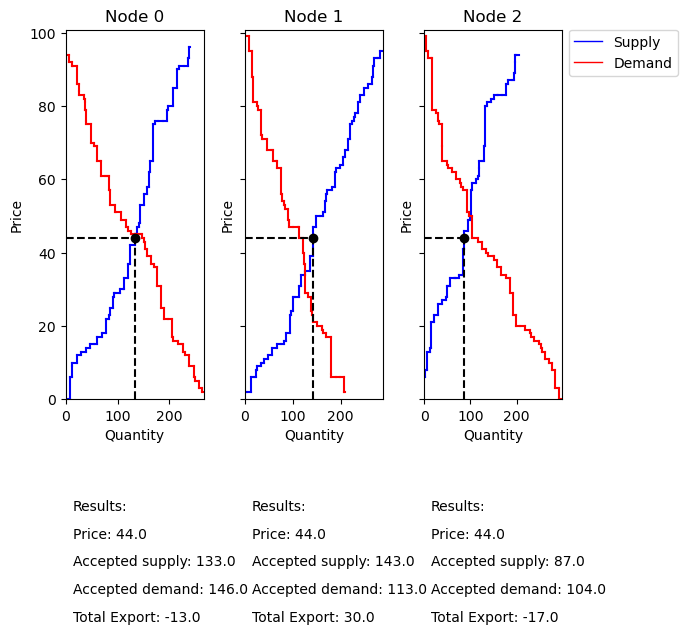

In [7]:
network = {"Line_0": (0, 1, 100), "Line_1": (1, 2, 100), "Line_2": (2, 0, 100)}

results = marketClearingLP(bids, network, nodes, plot=True, printMatrix=True)

# Defining a market clearing function

## Mathematical formulation

The objective of an Economic Dispatch problem is maximizing social welfare, here $c$ represents the price for the bid, which reflects the generation cost for generation, and the willingness to pay for demand. The variable $x$ represents the accepted power of a bid. Index j represent demand bids, whereas index i represents supply bids. The n index refers to the network node.

\begin{gather*}
    max \ z \ = \ \sum_{j} c_{j}^{D} x_{j}^{D} - \sum_{i} c_{i}^{G} x_{i}^{G}
  \end{gather*}
  




$s.t.:$
### Supply and demand bid constraint
The accepted volume of a bid is not allowed to exceed the maximum power offered
\begin{gather*}
    x_i^G \leq P_i^G \qquad \forall i
\end{gather*}

\begin{gather*}
    x_j^D \leq P_j^D \qquad \forall j
\end{gather*}

### Minimum power accepted per bid

\begin{gather*}
    x_j^D \geq 0 \qquad \forall j
\end{gather*}

\begin{gather*}
    x_i^G \geq 0 \qquad \forall i
\end{gather*}

When using pyomo some of the bounding constraints don't have to be defined explicitly such as minimum power accepted of each bid, since this is implicitly defined by defining a NonNegative domain.

### Line constraints

Power flow over a line $f_l$ is the limited by the capacity $F_l$ of the line
\begin{gather*}
    f_l \leq F_l \qquad \forall l
\end{gather*}
\begin{gather*}
    f_l \geq -F_l \qquad \forall l
\end{gather*}

Notice for line flow variables, we had to define the domain Reals to allow the flow in both directions.

### Nodal balance
Power balance of each node should be assured, meaning that at any given moment the power generated at a node should be equal to the consumption power and power flowing into the node. K is the incidence matrix which indicates which nodes are connected by each line, a value of 1 represents starting node, 0 represents no connection, and -1 represents an ending node. $\lambda_{n,t}$ represents the shadow price of the constraint which represents the nodal price of the node to which the constraint belongs to.

\begin{gather*}
\sum_{i} x_{i}^{G} - \sum_{j} x_{j}^{D} - \sum_{l} K_{nl}f_{l}  \hspace{.4cm} \leftrightarrow  \hspace{.4cm} w\lambda_{n,}
\end{gather*}


The incidence matrix in the code earlier was represented as a pandas dataframe where nodes are the rows, and lines are the columns.

#### External references:

1. Biggar, D. R., & Hesamzadeh, M. R. (Eds.). (2014). The Economics of Electricity Markets. Wiley. https://doi.org/10.1002/9781118775745

2. Hörsch, J., Ronellenfitsch, H., Witthaut, D., & Brown, T. (2017). Linear Optimal Power Flow Using Cycle Flows. arXiv. https://doi.org/10.48550/ARXIV.1704.01881

3. PyPSA documentation: https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html